In [ ]:
!pip install rouge

In [ ]:
import numpy as np
import pandas as pd

import re
import string
import csv
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from rouge import Rouge

In [ ]:
#train_df = pd.read_csv("/content/drive/MyDrive/Dataset/cnn_dailymail/train.csv", encoding='latin-1', usecols=['article', 'highlights'])
#test_df = pd.read_csv("/content/drive/MyDrive/Dataset/cnn_dailymail/test.csv", encoding='latin-1', usecols=['article', 'highlights'])
#val_df = pd.read_csv("/content/drive/MyDrive/Dataset/cnn_dailymail/validation.csv", encoding='latin-1', usecols=['article', 'highlights'])

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Dataset/cnn_dailymail_tokenlen/train.csv", encoding='latin-1')
test_df = pd.read_csv("/content/drive/MyDrive/Dataset/cnn_dailymail_tokenlen/test.csv", encoding='latin-1')
val_df = pd.read_csv("/content/drive/MyDrive/Dataset/cnn_dailymail_tokenlen/validation.csv", encoding='latin-1')

In [ ]:
train_df = train_df.rename(columns={"target_text":"highlights", "source_text":"article"})
test_df = test_df.rename(columns={"target_text":"highlights", "source_text":"article"})
val_df = val_df.rename(columns={"target_text":"highlights", "source_text":"article"})

In [ ]:
train_df=train_df[:8000]
test_df=test_df[:1000]

In [ ]:
train_data = train_df.drop(train_df.columns[0],axis=1)
train_data = train_df.reset_index(drop=True)
test_data = test_df.drop(test_df.columns[0],axis=1)
test_data = test_df.reset_index(drop=True)

In [ ]:
train_df.head()

,article,highlights
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [ ]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [ ]:
def clean_text(text, remove_stopwords=True):
    text = text.lower()
    text = text.split()
    tmp = []
    for word in text:
        if word in contractions:
            tmp.append(contractions[word])
        else:
            tmp.append(word)
    text = ' '.join(tmp)

    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)

    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words('english'))
        text = [w for w in text if w not in stops]
        text = ' '.join(text)

    return text

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

clean_summaries = []
for summary in train_data.highlights:
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print('Cleaning Summaries Complete')

clean_texts = []
for text in train_data.article:
    clean_texts.append(clean_text(text))
print('Cleaning Texts Complete')
del train_data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cleaning Summaries Complete
Cleaning Texts Complete


In [ ]:
clean_df = pd.DataFrame()
clean_df['text'] = clean_texts[:110000]
clean_df['summary'] = clean_summaries[:110000]
clean_df['summary'].replace('', np.nan, inplace=True)
clean_df.dropna(axis=0, inplace=True)

clean_df['summary'] = clean_df['summary'].apply(lambda x: '<sostok>' + ' ' + x + ' ' + '<eostok>')
del clean_texts
del clean_summaries

# Tokenizing Text And Summary Data

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(clean_df['text'], clean_df['summary'], test_size=0.1, random_state=0)
del clean_df

In [ ]:
t_tokenizer = Tokenizer()
t_tokenizer.fit_on_texts(list(train_x))

thresh = 4
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in t_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value


In [ ]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
t_max_features = total_count - count
print('Text Vocab: ', t_max_features)


% of rare words in vocabulary:  58.74885286020189
Total Coverage of rare words:  2.7994582053873196
Text Vocab:  37758


In [ ]:
s_tokenizer = Tokenizer()
s_tokenizer.fit_on_texts(list(train_y))

thresh = 6
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in s_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value


In [ ]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
s_max_features = total_count-count
print('Summary Vocab: ', s_max_features)

% of rare words in vocabulary:  78.12604872810256
Total Coverage of rare words:  11.12976194021567
Summary Vocab:  6518


In [ ]:
maxlen_text = 2400
maxlen_summ = 150


In [ ]:
val_x = test_x
t_tokenizer = Tokenizer(num_words=t_max_features)
t_tokenizer.fit_on_texts(list(train_x))
train_x = t_tokenizer.texts_to_sequences(train_x)
val_x = t_tokenizer.texts_to_sequences(val_x)

train_x = pad_sequences(train_x, maxlen=maxlen_text, padding='post')
val_x = pad_sequences(val_x, maxlen=maxlen_text, padding='post')


In [ ]:
val_y = test_y
s_tokenizer = Tokenizer(num_words=s_max_features)
s_tokenizer.fit_on_texts(list(train_y))
train_y = s_tokenizer.texts_to_sequences(train_y)
val_y = s_tokenizer.texts_to_sequences(val_y)

train_y = pad_sequences(train_y, maxlen=maxlen_summ, padding='post')
val_y = pad_sequences(val_y, maxlen=maxlen_summ, padding='post')


In [ ]:
print("Training Sequence", train_x.shape)
print('Target Values Shape', train_y.shape)
print('Test Sequence', val_x.shape)
print('Target Test Shape', val_y.shape)

Training Sequence (7200, 2400)
Target Values Shape (7200, 150)
Test Sequence (800, 2400)
Target Test Shape (800, 150)


In [ ]:
embeding_index = {}
embed_dim = 100
with open('/content/drive/MyDrive/Dataset/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeding_index[word] = coefs

In [ ]:

t_embed = np.zeros((t_max_features, embed_dim))
for word, i in t_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < t_max_features and vec is not None:
        t_embed[i] = vec

In [ ]:

s_embed = np.zeros((s_max_features, embed_dim))
for word, i in s_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < s_max_features and vec is not None:
        s_embed[i] = vec

In [ ]:

del embeding_index


# Model Architecture



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2400)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 2400, 100)    3775800     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 256),        234496      ['embedding[0][0]']              
                                 (None, 128),                                                 

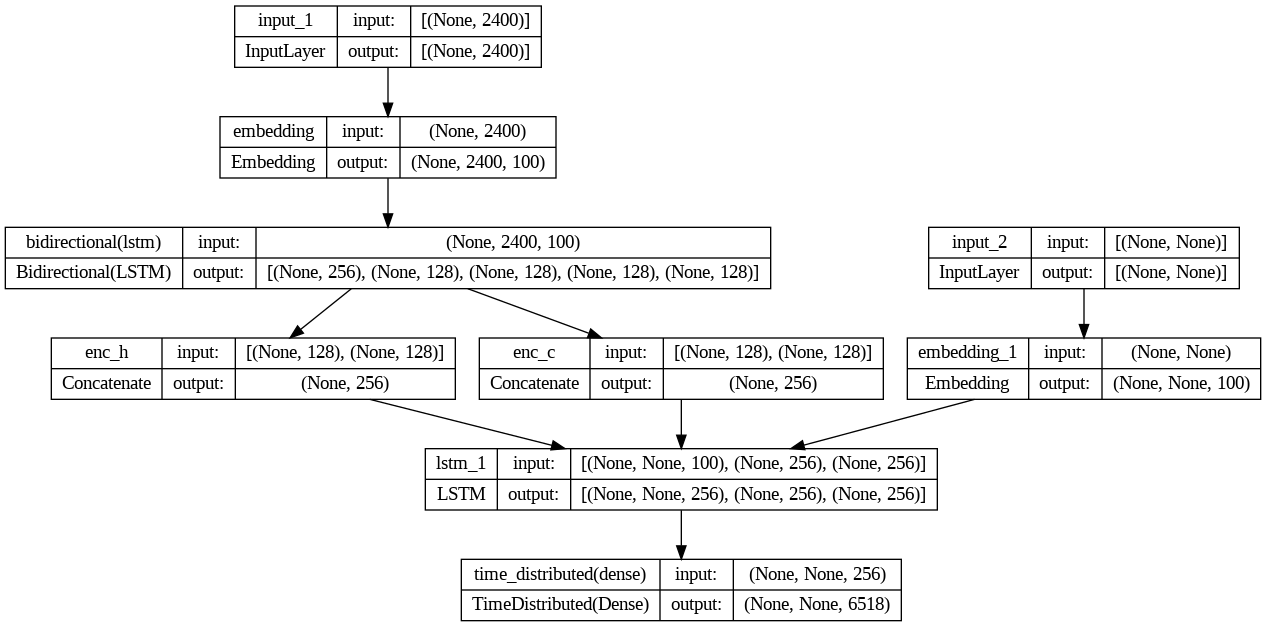

In [ ]:

latent_dim = 128
# Encoder
enc_input = Input(shape=(maxlen_text, ))
enc_embed = Embedding(t_max_features, embed_dim, input_length=maxlen_text, weights=[t_embed], trainable=False)(enc_input)
# h_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
# h_out, _, _ = h_lstm(enc_embed)
enc_lstm = Bidirectional(LSTM(latent_dim, return_state=True))
enc_output, enc_fh, enc_fc, enc_bh, enc_bc = enc_lstm(enc_embed)
enc_h = Concatenate(axis=-1, name='enc_h')([enc_fh, enc_bh])
enc_c = Concatenate(axis=-1, name='enc_c')([enc_fc, enc_bc])


#Decoder
dec_input = Input(shape=(None, ))
dec_embed = Embedding(s_max_features, embed_dim, weights=[s_embed], trainable=False)(dec_input)
dec_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
dec_outputs, _, _ = dec_lstm(dec_embed, initial_state=[enc_h, enc_c])

dec_dense = TimeDistributed(Dense(s_max_features, activation='softmax'))
dec_output = dec_dense(dec_outputs)

model = Model([enc_input, dec_input], dec_output)
model.summary()

plot_model(
    model,
    to_file='./seq2seq_encoder_decoder.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
model.fit([train_x, train_y[:, :-1]], train_y.reshape(train_y.shape[0], train_y.shape[1], 1)[:, 1:], epochs=10, callbacks=[early_stop], batch_size=128, verbose=2, validation_data=([val_x, val_y[:, :-1]], val_y.reshape(val_y.shape[0], val_y.shape[1], 1)[:, 1:]))

Epoch 1/10
57/57 - 66s - loss: 3.2372 - val_loss: 2.1568 - 66s/epoch - 1s/step
Epoch 2/10
57/57 - 52s - loss: 2.1270 - val_loss: 2.0836 - 52s/epoch - 914ms/step
Epoch 3/10
57/57 - 51s - loss: 2.0919 - val_loss: 2.0827 - 51s/epoch - 895ms/step
Epoch 4/10
57/57 - 58s - loss: 2.0790 - val_loss: 2.0547 - 58s/epoch - 1s/step
Epoch 5/10
57/57 - 58s - loss: 2.0695 - val_loss: 2.0460 - 58s/epoch - 1s/step
Epoch 6/10
57/57 - 53s - loss: 2.0607 - val_loss: 2.0407 - 53s/epoch - 929ms/step
Epoch 7/10
57/57 - 57s - loss: 2.0518 - val_loss: 2.0281 - 57s/epoch - 1s/step
Epoch 8/10
57/57 - 54s - loss: 2.0427 - val_loss: 2.0202 - 54s/epoch - 946ms/step
Epoch 9/10
57/57 - 53s - loss: 2.0331 - val_loss: 2.0097 - 53s/epoch - 934ms/step
Epoch 10/10
57/57 - 53s - loss: 2.0247 - val_loss: 1.9996 - 53s/epoch - 932ms/step


# Inference

In [ ]:
enc_model = Model(inputs=enc_input, outputs=[enc_h, enc_c])

dec_init_state_h = Input(shape=(latent_dim*2, ))
dec_init_state_c = Input(shape=(latent_dim*2, ))

dec_out, dec_h, dec_c = dec_lstm(dec_embed, initial_state=[dec_init_state_h, dec_init_state_c])
dec_final = dec_dense(dec_out)

dec_model = Model([dec_input]+[dec_init_state_h, dec_init_state_c], [dec_final]+[dec_h, dec_c])

In [ ]:
def generate_summary(input_seq):
    h, c = enc_model.predict(input_seq)

    next_token = np.zeros((1, 1))
    next_token[0, 0] = s_tokenizer.word_index['sostok']
    output_seq = ''

    stop = False
    count = 0

    while not stop:
        if count > 100:
            break
        decoder_out, state_h, state_c = dec_model.predict([next_token]+[h, c])
        token_idx = np.argmax(decoder_out[0, -1, :])

        if token_idx == s_tokenizer.word_index['eostok']:
            stop = True
        elif token_idx > 0 and token_idx != s_tokenizer.word_index['sostok']:
            token = s_tokenizer.index_word[token_idx]
            output_seq = output_seq + ' ' + token

        next_token = np.zeros((1, 1))
        next_token[0, 0] = token_idx
        h, c = state_h, state_c
        count += 1

    return output_seq

In [ ]:
test_inputs = [clean_text(sent) for sent in test_data.article]
test_inputs = t_tokenizer.texts_to_sequences(list(test_inputs))
test_inputs = pad_sequences(test_inputs, maxlen=maxlen_text, padding='post')

In [ ]:
hyps = []
with open('./result.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Article', 'Original Summary', 'Model Output'])
    for i in range(500):
        our_summ = generate_summary(test_inputs[i].reshape(1, maxlen_text))
        hyps.append(our_summ)
        writer.writerow([test_data.article[i], test_data.highlights[i], our_summ])

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 27ms/step


In [ ]:
rouge = Rouge()
Rouge_scores = rouge.get_scores(hyps, test_data.highlights, avg=True, ignore_empty=True)
Rouge_scores

{'rouge-1': {'r': 0.03232956978958278, 'p': 0.65, 'f': 0.06123616997581238},
 'rouge-2': {'r': 0.0024193664190485078,
  'p': 0.03933333333333333,
  'f': 0.004502683159021695},
 'rouge-l': {'r': 0.03232956978958278, 'p': 0.65, 'f': 0.06123616997581238}}

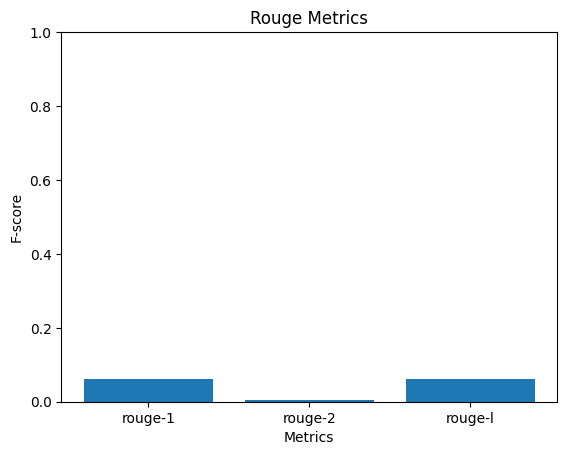

In [ ]:
import matplotlib.pyplot as plt
from rouge import Rouge

def plot_rouge_scores(rouge_scores):
    metrics = ['rouge-1', 'rouge-2', 'rouge-l']
    scores = [rouge_scores['rouge-1']['f'], rouge_scores['rouge-2']['f'], rouge_scores['rouge-l']['f']]

    plt.bar(metrics, scores)
    plt.ylim([0, 1])  # Set the y-axis limits to ensure consistent scale

    plt.xlabel('Metrics')
    plt.ylabel('F-score')
    plt.title('Rouge Metrics')

    plt.savefig('rouge_metrics.png')
    plt.show()

# Generate the PNG image
plot_rouge_scores(Rouge_scores)

In [ ]:

import matplotlib.pyplot as plt
from rouge import Rouge

#def plot_rouge_scores(rouge_scores):
    metrics = ['rouge-1', 'rouge-2', 'rouge-l']
    scores = [rouge_scores['rouge-1']['f'], rouge_scores['rouge-2']['f'], rouge_scores['rouge-l']['f']]

    plt.bar(metrics, scores)
    plt.ylim([0, 1])  # Set the y-axis limits to ensure consistent scale

    plt.xlabel('Metrics')
    plt.ylabel('F-score')
    plt.title('Rouge Metrics')

    plt.savefig('rouge_metrics.png')
    plt.show()

# Example rouge scores
example_scores = {
    'rouge-1': {'f': 0.14070871747705416, 'p': 0.2839388404120816, 'r': 0.09994767488522659},
    'rouge-2': {'f': 0.018568887340487096, 'p': 0.03314324664559827, 'r': 0.014108505606093532},
    'rouge-l': {'f': 0.13292791220057282, 'p': 0.27001709387906314, 'r': 0.0942964947143182}
}

# Generate the PNG image
plot_rouge_scores(example_scores)